# Load the libraries

In [ ]:
## TRAINING SET : MERGED mRNA DATA , TESTING DATA:  (GSE38129) : 60 samples (30 control , 30 ESCC), MODEL: XGBoost

In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import Lasso
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np

np.random.seed(7)

# Read the data

In [4]:
df_train = pd.read_csv("DS/mRNA_DS_preprocessed_training_data.csv") # read the training data

In [5]:
df_test = pd.read_csv("DS/mRNA_DS_test_data.csv") # read the test data

# Data Preprocessing

In [6]:
df_train = df_train.T # transpose the data
df_test = df_test.T

In [7]:
#df_test = df_test[:-1]

In [8]:
#Transform the input data
df_train.rename(columns=df_train.iloc[0], inplace = True)
df_train.drop(df_train.index[0], inplace = True)
df_train=df_train.reset_index()

In [9]:
#Transform the input data
df_test.rename(columns=df_test.iloc[-1], inplace = True)
df_test.drop(df_test.index[-1], inplace = True)
df_test=df_test.reset_index()

In [10]:
metadata_test = pd.read_csv("DS/mRNA_DS_metadata_col_test_info.csv") # read the column information (cancer/non cancer)

In [11]:
df_test= df_test.merge(metadata_test, left_on="index", right_on= "Unnamed: 0")

In [12]:
df_test['title0'] = df_test['title0'].replace('(?i)mucosa|normal|healthy', 0, regex=True) # replace the names to 0 
 

In [13]:
df_test['title0'] = df_test['title0'].replace('(?i)Tumor|Cancer|carcinoma', 1, regex=True)

In [14]:
df_test['title0'].value_counts()

title0
0    30
1    30
Name: count, dtype: int64

In [15]:
df_test = df_test[pd.to_numeric(df_test['title0'], errors='coerce').notnull()]#remove all non-numeric data from the column.

In [16]:
df_test= df_test.drop(['index', 'Unnamed: 0'], axis=1)

In [17]:
df_test= df_test.rename(columns={"title0": "index"})

In [18]:
X_test=df_test.drop("index",axis=1)
y_test=df_test['index']

In [19]:
metadata_train = pd.read_csv("DS/mRNA_DS_metadata_col_info.csv")

In [20]:
df_train= df_train.merge(metadata_train, left_on="index", right_on= "Unnamed: 0")

In [21]:
df_train['title0'] = df_train['title0'].replace('(?i)mucosa|normal|healthy', 0, regex=True)


In [22]:
df_train['title0'] = df_train['title0'].replace('(?i)Tumor|Cancer|carcinoma', 1, regex=True)

In [23]:
df_train = df_train[pd.to_numeric(df_train['title0'], errors='coerce').notnull()]#remove all non-numeric data from the column.

In [24]:
df_train= df_train.drop(['index', 'Unnamed: 0'], axis=1)

In [25]:
df_train= df_train.rename(columns={"title0": "index"})

In [26]:
df_train['index'].value_counts()

index
0    111
1    108
Name: count, dtype: int64

In [27]:
df_train= df_train.apply(pd.to_numeric)

# t-SNE

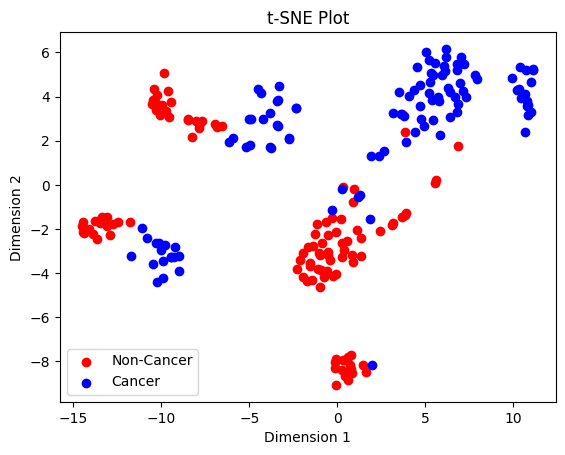

In [28]:
from sklearn.manifold import TSNE
# t-SNE
tsne = TSNE(n_components=2,perplexity=40)
embedded_data = tsne.fit_transform(df_train)

# Step 2: Separate data points by class
class_1_indices = np.where(df_train['index'] == 0)[0]
class_2_indices = np.where(df_train['index'] == 1)[0]

class_1_data = embedded_data[class_1_indices]
class_2_data = embedded_data[class_2_indices]

# Step 3: Plot the t-SNE plot with different colors for each class
plt.scatter(class_1_data[:, 0], class_1_data[:, 1], color='red', label='Non-Cancer')
plt.scatter(class_2_data[:, 0], class_2_data[:, 1], color='blue', label='Cancer')

plt.title('t-SNE Plot')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

#### t-distributed stochastic neighbor embedding (t-SNE) is a statistical method for visualizing high-dimensional data by giving each datapoint a location in a two dimensional map.  In the plot above we used perplexity of 40 for visualizing the t-SNE, but we didnt do any dimensionality reduction with it. Blue points are Cancer and the red are non-cancer.

In [29]:
X=df_train.drop("index",axis=1)
y=df_train['index']

In [30]:
X=X.astype('int')

In [31]:
y=y.astype('int')

# Feature Selection (LASSO)

In [32]:
# LASSO model:
lasso = Lasso(alpha=1)
# fitting the model:
lasso.fit(X, y)
# select all coefficients and the feature names
lasso_coefs = lasso.coef_
feature_names = X.columns

# collect the selected features:
selected_feature_indices = np.nonzero(lasso_coefs)[0]
selected_features = [feature_names[i] for i in selected_feature_indices]
X_selected = X.iloc[:, selected_feature_indices]

In [33]:
len(selected_features)

98

# Test train split

In [34]:
X_train = X_selected
y_train = y

In [35]:
y_test.value_counts(),y_train.value_counts()

(index
 0    30
 1    30
 Name: count, dtype: int64,
 index
 0    111
 1    108
 Name: count, dtype: int64)

# Cross validation

In [36]:
model = xgb.XGBClassifier(random_state=42)

# Defining parameter range
param_grid = {
    'max_depth': [3,5],
    'learning_rate': [0.1 ,0.01, 0.001],
    'n_estimators': [100,200],
    'gamma': [ 0.1,0.01,0.001],
    'subsample': [0.8,1]
}

grid = GridSearchCV(model, param_grid, refit=True, verbose=3)

# Fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8;, score=0.864 total time=   0.3s
[CV 2/5] END gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8;, score=0.932 total time=   0.1s
[CV 3/5] END gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8;, score=0.977 total time=   0.1s
[CV 4/5] END gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8;, score=0.932 total time=   0.2s
[CV 5/5] END gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8;, score=0.953 total time=   0.1s
[CV 1/5] END gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1;, score=0.886 total time=   0.1s
[CV 2/5] END gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1;, score=0.955 total time=   0.1s
[CV 3/5] END gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1;, score=0

[CV 1/5] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8;, score=0.818 total time=   0.2s
[CV 2/5] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8;, score=0.955 total time=   0.2s
[CV 3/5] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8;, score=0.977 total time=   0.2s
[CV 4/5] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8;, score=0.932 total time=   0.2s
[CV 5/5] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8;, score=0.884 total time=   0.2s
[CV 1/5] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1;, score=0.841 total time=   0.2s
[CV 2/5] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1;, score=0.773 total time=   0.2s
[CV 3/5] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1;, score=0.955 total time=   0.2s
[CV 4/5] END gamma=0.1, learni

[CV 5/5] END gamma=0.01, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1;, score=0.953 total time=   0.2s
[CV 1/5] END gamma=0.01, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8;, score=0.909 total time=   0.1s
[CV 2/5] END gamma=0.01, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8;, score=0.932 total time=   0.2s
[CV 3/5] END gamma=0.01, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8;, score=0.977 total time=   0.2s
[CV 4/5] END gamma=0.01, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8;, score=0.932 total time=   0.1s
[CV 5/5] END gamma=0.01, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8;, score=0.953 total time=   0.1s
[CV 1/5] END gamma=0.01, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1;, score=0.886 total time=   0.1s
[CV 2/5] END gamma=0.01, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1;, score=0.977 total time=   0.1s
[CV 3/5] END gamma=0.01, learn

[CV 4/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=100, subsample=1;, score=0.864 total time=   0.1s
[CV 5/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=100, subsample=1;, score=0.884 total time=   0.1s
[CV 1/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=200, subsample=0.8;, score=0.659 total time=   0.2s
[CV 2/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=200, subsample=0.8;, score=0.886 total time=   0.2s
[CV 3/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=200, subsample=0.8;, score=0.932 total time=   0.2s
[CV 4/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=200, subsample=0.8;, score=0.886 total time=   0.2s
[CV 5/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=200, subsample=0.8;, score=0.884 total time=   0.3s
[CV 1/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=200, subsample=1;, score=0.659 total time=   0.3s
[CV 2/5] END g

[CV 1/5] END gamma=0.001, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1;, score=0.886 total time=   0.1s
[CV 2/5] END gamma=0.001, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1;, score=0.977 total time=   0.1s
[CV 3/5] END gamma=0.001, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1;, score=0.977 total time=   0.1s
[CV 4/5] END gamma=0.001, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1;, score=0.909 total time=   0.1s
[CV 5/5] END gamma=0.001, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1;, score=0.953 total time=   0.1s
[CV 1/5] END gamma=0.001, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=0.795 total time=   0.1s
[CV 2/5] END gamma=0.001, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=0.955 total time=   0.2s
[CV 3/5] END gamma=0.001, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=0.977 total time=   0.1s
[CV 4/5] END gamma=0.00

[CV 3/5] END gamma=0.001, learning_rate=0.001, max_depth=5, n_estimators=100, subsample=0.8;, score=0.932 total time=   0.1s
[CV 4/5] END gamma=0.001, learning_rate=0.001, max_depth=5, n_estimators=100, subsample=0.8;, score=0.909 total time=   0.1s
[CV 5/5] END gamma=0.001, learning_rate=0.001, max_depth=5, n_estimators=100, subsample=0.8;, score=0.884 total time=   0.1s
[CV 1/5] END gamma=0.001, learning_rate=0.001, max_depth=5, n_estimators=100, subsample=1;, score=0.659 total time=   0.1s
[CV 2/5] END gamma=0.001, learning_rate=0.001, max_depth=5, n_estimators=100, subsample=1;, score=0.614 total time=   0.1s
[CV 3/5] END gamma=0.001, learning_rate=0.001, max_depth=5, n_estimators=100, subsample=1;, score=0.955 total time=   0.1s
[CV 4/5] END gamma=0.001, learning_rate=0.001, max_depth=5, n_estimators=100, subsample=1;, score=0.864 total time=   0.2s
[CV 5/5] END gamma=0.001, learning_rate=0.001, max_depth=5, n_estimators=100, subsample=1;, score=0.930 total time=   0.2s
[CV 1/5] E

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             param_grid={'gamma': [0.1, 0.01, 0.001],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 5], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1]},
             verbose=3)

# choose the best hyperparameters

In [37]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'gamma': 0.001, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.001, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)


In [38]:
# Select columns in df1 based on columns in df2
X_test = X_test.loc[:, X_train.columns]

In [39]:
X_test = X_test.astype('int')

In [40]:
model_xgb = grid.best_estimator_
model_xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.001, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [41]:
y_proba = model_xgb.fit(X_train, y_train).predict_proba(X_test)[:,1]

# ROC Curve and Classification report

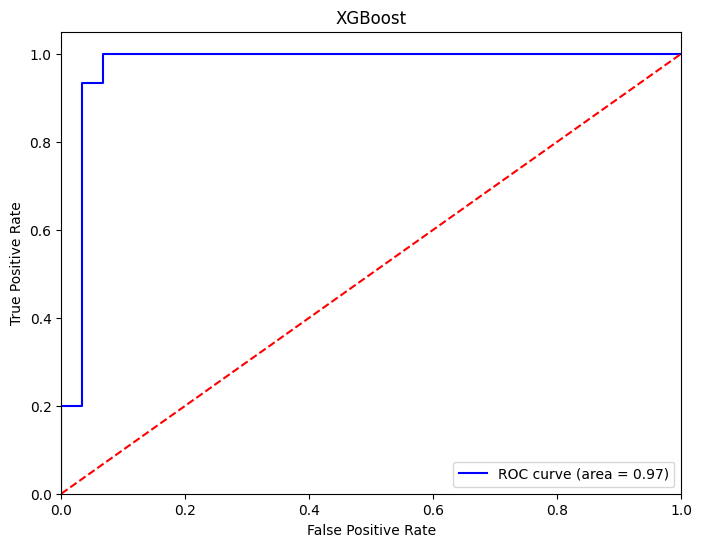

In [42]:
from sklearn.metrics import roc_curve, auc
# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost')
plt.legend(loc='lower right')
plt.show()

### The ROC curve above shows that the XGBoost model has an AUC of 0.97 which indicates that the model preformed good in classification of non cancer and cancer.

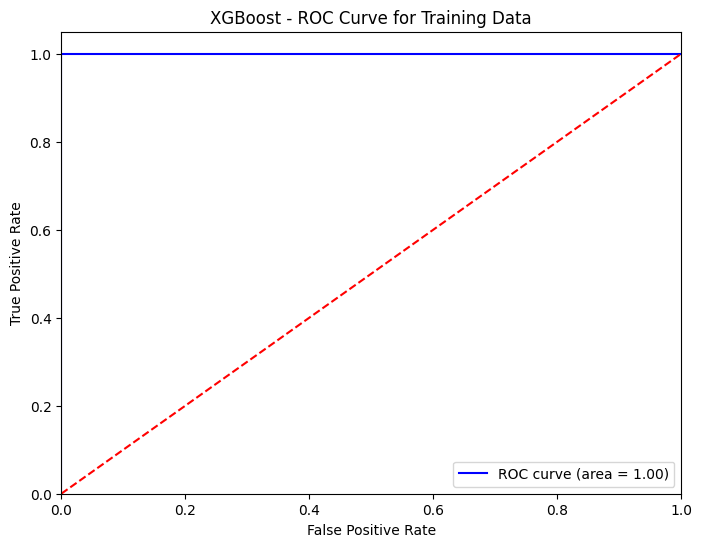

In [43]:
# Predict probabilities for the training data
y_train_proba = model_xgb.predict_proba(X_train)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_proba)

# Calculate the area under the ROC curve (AUC) for training data
roc_auc_train = auc(fpr_train, tpr_train)

# Plot the ROC curve for training data
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', label='ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost - ROC Curve for Training Data')
plt.legend(loc='lower right')
plt.show()

#### In the ROC curve above we can see that the AUC value of 1 for the train set which indicates the model's flawless ability to distinguish between positive and negative classes during training, showcasing excellent performance on the training data.

In [45]:
from sklearn.metrics import classification_report, confusion_matrix
grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93        30
           1       0.88      1.00      0.94        30

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



### The model displayed high precision and recall for both classes, resulting in an overall F1-score of 0.93, indicating its strong performance on the test dataset.

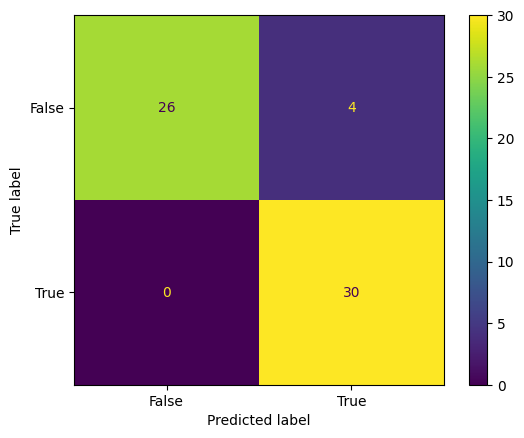

In [46]:
#######CONFUSION MATRIX ###########
from sklearn import metrics
y_test_pred_xgb = model_xgb.predict(X_test)
confusion_matrix_test = metrics.confusion_matrix(y_test, y_test_pred_xgb)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_test, display_labels = [False, True])
cm_display.plot()
plt.show()

### The XGBoost model achieved 26 true positive predictions and 30 true negative predictions, with only 4 false positives and no false negatives, indicating strong overall performance in correctly classifying positive and negative samples.

In [47]:
total1=sum(sum(confusion_matrix_test))
#####from confusion matrix calculate accuracy
accuracy1=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
print('Specificity : ', specificity1)

Accuracy :  0.9333333333333333
Sensitivity :  0.8666666666666667
Specificity :  1.0


### The XGBoost model demonstrated strong performance with an accuracy of 93.3%, correctly identifying all negative samples with a specificity of 100% and achieving a high sensitivity of 86.7% for positive samples.

# Feature importance:

In [48]:
# for important features:
important_feat = model_xgb.feature_importances_
#get indices of those important features
idx = important_feat.argsort(kind= "quicksort")
idx= idx[::-1][:50]

In [49]:
df1 = X_selected.T

In [50]:
top_met = df1.iloc[idx]

In [51]:
top_met.index

Index(['CRISP3', 'TRIP13', 'RPN1', 'CRNN', 'ALDH9A1', 'ECT2', 'HSPB8', 'MCM2',
       'EMP1', 'SIM2', 'RAB11FIP1', 'COL1A1', 'EFNA1', 'IGFBP3', 'KANK1',
       'CFD', 'CLIC3', 'ID4', 'CH25H', 'LCN2', 'DHRS1', 'IGF2BP2', 'MMP10',
       'ANO1', 'MYH10', 'LAMC2', 'SLK', 'ZBTB16', 'AIM2', 'AQP3', 'COL5A2',
       'UCHL1', 'ENTPD6', 'GALE', 'ATP6V1D', 'HSPBAP1', 'GPX3', 'LEPROTL1',
       'NT5C2', 'SCNN1A', 'FSCN1', 'ERCC3', 'TMPRSS11D', 'RHCG', 'PTN',
       'CRABP2', 'DHRS2', 'GABRP', 'FLG', 'TMF1'],
      dtype='object')

In [52]:
X_selected.columns

Index(['ACLY', 'ACPP', 'AIM2', 'ALDH9A1', 'ALOX12', 'ANO1', 'AQP3', 'ATP6V1D',
       'CCNG2', 'CES2', 'CFD', 'CH25H', 'CLIC3', 'COL1A1', 'COL5A2', 'CRABP2',
       'CRISP3', 'CRNN', 'CYP4B1', 'DHRS1', 'DHRS2', 'DUOX1', 'DUSP5', 'ECM1',
       'ECT2', 'EFNA1', 'EMP1', 'ENTPD6', 'ERCC3', 'FLG', 'FSCN1', 'GABRP',
       'GALE', 'GALNT1', 'GPX3', 'HOPX', 'HSPB8', 'HSPBAP1', 'HSPD1', 'ID4',
       'IFI35', 'IGF2BP2', 'IGFBP3', 'IL1RN', 'INPP1', 'KANK1', 'KLK13',
       'KRT4', 'LAMC2', 'LCN2', 'LEPROTL1', 'LYPD3', 'MAL', 'MCM2', 'MMP10',
       'MUC1', 'MYH10', 'NDRG2', 'NT5C2', 'PCSK5', 'PHLDA1', 'PITX1',
       'PPP1R3C', 'PSMB9', 'PTN', 'RAB11FIP1', 'RANBP9', 'RHCG', 'RND3',
       'RPN1', 'RUVBL1', 'SCNN1A', 'SERPINB13', 'SERPINB2', 'SIM2', 'SLC2A1',
       'SLK', 'SLURP1', 'SPINK5', 'SPRR3', 'SSRP1', 'STK24', 'SYNPO2L',
       'TAPBP', 'TFAP2B', 'TGIF1', 'TIAM1', 'TJP1', 'TMF1', 'TMPRSS11D',
       'TMPRSS11E', 'TRIP13', 'TSPAN6', 'TST', 'TYMP', 'UCHL1', 'ZBTB16',
       'ZNF185'],
  

In [53]:
from matplotlib import pyplot as plt

Text(0.5, 0, 'Xgboost Feature Importance')

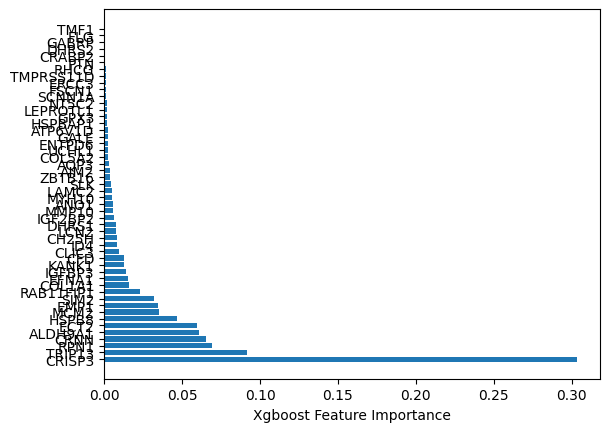

In [54]:
sorted_idx = model_xgb.feature_importances_.argsort()
plt.barh(top_met.index, model_xgb.feature_importances_[idx])[::-1]
plt.xlabel("Xgboost Feature Importance")

#### The above plot shows the feature importance from low importance to high importance found by the model.